In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import seaborn as sns

%matplotlib inline

# Предобработка данных

Имеются данные об индексе счастья, а также других индексах, на него влияющих, в разных странах мира за период 2008-2020 гг. Попробуем отобрать факторы и построить модель, которая наилучшим образом объясняет, от чего люди в разных странах мира счастливы.<br>
Имеем факторы:<br>
1. country name - название страны
2. year - год
3. LOg GDP per capita - ВВП на душу населения (долл.)
4. Social support - уровень социальной политики и поддержки граждан
5. Healthy life expectancy at birth - ожидаемая продолжительность жизни при рождении (кол-во лет)
6. Freedom to make life choices - уровень свободы выбора граждан
7. Generosity - щедрость (включает в себя пожертвования граждан на благотворительность)
8. Perceptions of corruption - индекс восприятия коррупции
9. Positive affect - индекс позитивного эффекта (приятные мелочи в жизни)
10. Negative affect - индекс негативного эффекта (неприятные мелочи в жизни)

Результирующая - Life Ladder - индекс счастья. Измеряется от 0 до 10.

In [37]:
#загрузим датасет
df = pd.read_csv('world-happiness-report.csv')
df

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268
...,...,...,...,...,...,...,...,...,...,...,...
1944,Zimbabwe,2016,3.735,7.984,0.768,54.40,0.733,-0.095,0.724,0.738,0.209
1945,Zimbabwe,2017,3.638,8.016,0.754,55.00,0.753,-0.098,0.751,0.806,0.224
1946,Zimbabwe,2018,3.616,8.049,0.775,55.60,0.763,-0.068,0.844,0.710,0.212
1947,Zimbabwe,2019,2.694,7.950,0.759,56.20,0.632,-0.064,0.831,0.716,0.235


In [38]:
#посмотрим на характеристики датасета
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      1949 non-null   object 
 1   year                              1949 non-null   int64  
 2   Life Ladder                       1949 non-null   float64
 3   Log GDP per capita                1913 non-null   float64
 4   Social support                    1936 non-null   float64
 5   Healthy life expectancy at birth  1894 non-null   float64
 6   Freedom to make life choices      1917 non-null   float64
 7   Generosity                        1860 non-null   float64
 8   Perceptions of corruption         1839 non-null   float64
 9   Positive affect                   1927 non-null   float64
 10  Negative affect                   1933 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 167.6+ KB


Видим пропуски по многим строкам. Можно бы было в целом удалить эти пропуски, но данных и так не очень много, поэтому используем метод заполнения медианой с категоризацией по странам.

In [39]:
#сгруппируем данные по странам и вычислим медиану каждого фактора в группе
grouped = df.groupby('Country name')
medians = grouped.median()

#создадим функцию для заполнения пропусков
def fill_missing_by_country(row):
    country = row['Country name']
    for column in df.columns:
        if pd.isnull(row[column]):
            row[column] = medians.loc[country, column]
    return row

#применим функцию к датасету
df = df.apply(fill_missing_by_country, axis=1)

#снова посмотрим на пропуски
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      1949 non-null   object 
 1   year                              1949 non-null   int64  
 2   Life Ladder                       1949 non-null   float64
 3   Log GDP per capita                1930 non-null   float64
 4   Social support                    1948 non-null   float64
 5   Healthy life expectancy at birth  1913 non-null   float64
 6   Freedom to make life choices      1949 non-null   float64
 7   Generosity                        1930 non-null   float64
 8   Perceptions of corruption         1921 non-null   float64
 9   Positive affect                   1947 non-null   float64
 10  Negative affect                   1948 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 167.6+ KB


Пропусков стало гораздо меньше, скорее всего они связаны с тем, что по стране нет каких-либо данных. В основном, отсутствуют данные по восприятию коррупции в странах Средней Азии и Востока. Эти и другие факторы мы особо никак не можем восстановить, потому что они у же пересчитаны в индексы. Удалим строки с пропущенными значениями.

In [40]:
df.dropna(inplace=True)

Далее, так как мне хотелось посмотреть влияет ли развитость страны на уровень счастья, я создам фиктивную переменную, где 1 - развитая страна, 0 - развивающаяся. Поделила я их на свое усмотрение.

In [41]:
#список развитых стран
developed_countries = ['Australia', 'Austria', 'Belgium', 'Canada', 'Denmark', 'Finland', 'France', 'Germany', 'Iceland', 'Ireland', 'Italy', 'Japan', 'Luxembourg', 'Netherlands', 'New Zealand', 'Norway', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'United States']

#добавим столбец с фиктивной переменной
df['Developed'] = df['Country name'].apply(lambda x: 1 if x in developed_countries else 0)

Далее посмотрим на распределение данных.

<Axes: xlabel='Life Ladder', ylabel='Density'>

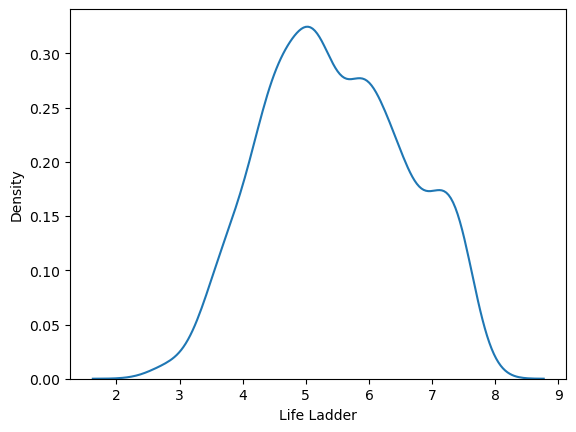

In [42]:
#заигнорируем предупреждения, чтобы не мешали
import warnings
warnings.filterwarnings("ignore")

sns.distplot(df['Life Ladder'], hist=False , kde=True)

Методы нормализации данных особо не дали здесь никакого результата, поэтому было принято решение оставить как есть. В целом, распределение похоже на нормальное с небольшими лесенками.

# Отбор факторов

In [43]:
#удалим текстовый столбец с названиями стран
df.drop('Country name', axis=1, inplace=True)

In [44]:
#создадим обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

X = df.drop(['Life Ladder'], axis=1)
y = df[["Life Ladder"]]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

Для начала посмотрим на коэффициенты корреляции и визуально и логически оценим значимость факторов.

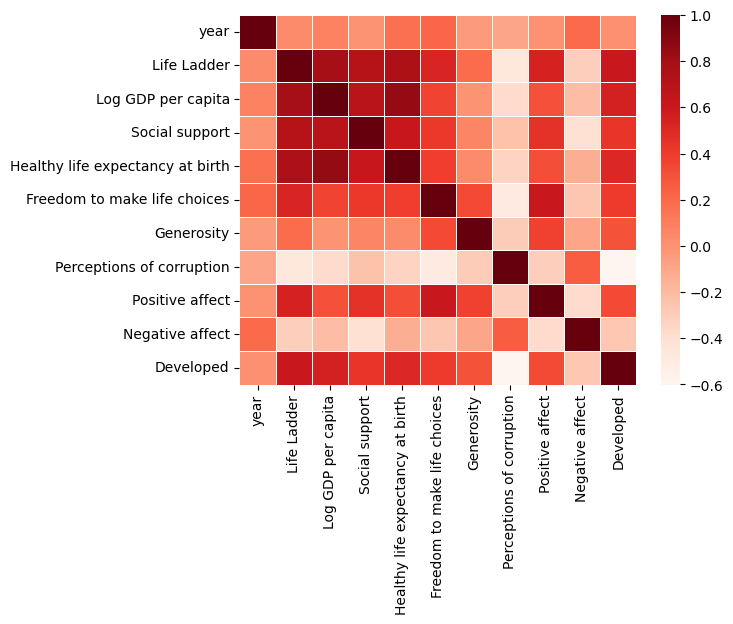

In [45]:
#корреляционный анализ
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap="Reds", linewidths=.5)
plt.show()

В целом, все параметры в той или иной степень влияют на результат. Поэтому визуально сложно определить какие факторы лучше взять в модель. Было принято решение проверить по пермутационной важности.

In [46]:
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train_X, train_y)
perm_importance = permutation_importance(model, test_X, test_y)
importance = perm_importance.importances_mean
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
1,Log GDP per capita,0.218957
7,Positive affect,0.075911
3,Healthy life expectancy at birth,0.073260
2,Social support,0.060060
9,Developed,0.020983
6,Perceptions of corruption,0.009528
4,Freedom to make life choices,0.009248
0,year,0.004653
5,Generosity,0.003650
8,Negative affect,0.000537


Результаты пермутационной важности не особо радужные, лучше использовать другой способ. Попробуем метод Random Forest

In [49]:
#создадим и обучим модель Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_X, train_y.values.ravel())

#важность признаков
feature_importance = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': train_X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_n = 10
top_features = feature_importance_df.head(top_n)
print("Топ-N наиболее важных признаков:")
print(top_features)

Топ-N наиболее важных признаков:
                            Feature  Importance
1                Log GDP per capita    0.510690
3  Healthy life expectancy at birth    0.225521
7                   Positive affect    0.095580
2                    Social support    0.046784
4      Freedom to make life choices    0.026791
5                        Generosity    0.024354
8                   Negative affect    0.021641
6         Perceptions of corruption    0.020521
9                         Developed    0.015603
0                              year    0.012514


Результаты уже лучше, точно возьмем в модель Lg GDP per capita, Healthy life expectancy at birth, Positive affect. Но попробуем еще метод Lasso

In [51]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.01)  #задаем параметр регуляризации
lasso_model.fit(train_X, train_y)

#коэффициенты модели
coefficients = lasso_model.coef_

#важность признаков
feature_importance_df = pd.DataFrame({'Feature': train_X.columns, 'Importance': abs(coefficients)})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_n = 10
top_features = feature_importance_df.head(top_n)
print("Топ-N наиболее важных признаков с использованием Lasso:")
print(top_features)

Топ-N наиболее важных признаков с использованием Lasso:
                            Feature  Importance
7                   Positive affect    1.350707
2                    Social support    0.628049
4      Freedom to make life choices    0.578943
9                         Developed    0.385110
1                Log GDP per capita    0.382618
6         Perceptions of corruption    0.085617
5                        Generosity    0.054214
3  Healthy life expectancy at birth    0.039319
0                              year    0.016668
8                   Negative affect    0.000000


Другое дело! Логически и фактически эта модель мне понравилась больше всего, было принято решение взять в модель слудующие факторы:
1. Log GDP per capita
2. Developed
3. Healthy life expectancy at birth
4. Positive affect
5. Social support
6. Freedom to make life choices
Факторов много, но и результирующая у нас достаточно субъективная, поэтому берем все перечисленные выше и строим модель.

In [52]:
train_X_selected = train_X[['Log GDP per capita', 'Developed', 'Healthy life expectancy at birth', 'Positive affect', 'Social support', 'Freedom to make life choices']]
test_X_selected = test_X[['Log GDP per capita', 'Developed', 'Healthy life expectancy at birth', 'Positive affect', 'Social support', 'Freedom to make life choices']]

model_selected_features = LinearRegression()

model_selected_features.fit(train_X_selected, train_y)

predicted_y_selected_features = model_selected_features.predict(test_X_selected)

In [53]:
from sklearn.metrics import r2_score, mean_absolute_error
r2 = r2_score(test_y, predicted_y_selected_features)
mae = mean_absolute_error(test_y, predicted_y_selected_features)
print("R^2 Score (Selected Features):", r2)
print("Mean Absolute Error (Selected Features):", mae)

R^2 Score (Selected Features): 0.7771001015621319
Mean Absolute Error (Selected Features): 0.39606712031787233


В целом, модель получилась достаточно хорошая, с не очень большим R^2, но и маленькой ошибкой. Мне понравилась эта модель с точки зрения логики зависимости результата от переменных. 

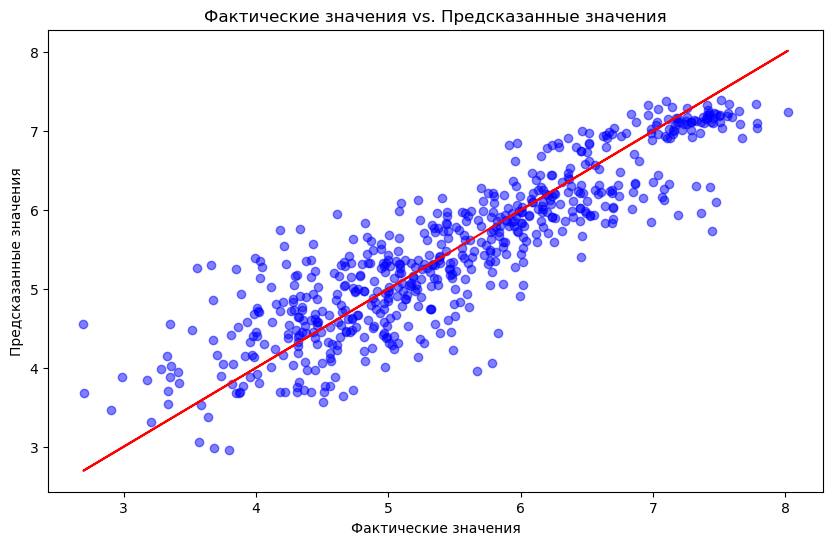

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(test_y, predicted_y_selected_features, color='blue', alpha=0.5)
plt.plot(test_y, test_y, color='red')
plt.title('Фактические значения vs. Предсказанные значения')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.show()